In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Lambda
from keras.layers import MaxPooling2D,UpSampling2D,Concatenate,Conv2DTranspose
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.models import load_model
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.callbacks import LearningRateScheduler,Callback
from keras.optimizers import RMSprop
import cv2
from math import *
from keras.applications.vgg16 import VGG16 
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import h5py
from keras.utils import to_categorical
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from keras.preprocessing.image import ImageDataGenerator
from skimage import measure
from skimage import img_as_float32
from imutils import contours
import imutils
import scipy.misc as sm
from PIL import Image
from timeit import default_timer as timer

from numba import *
import os
import cv2
from numba import *

os.environ['NUMBAPRO_NVVM']=r'/usr/local/cuda-9.0/nvvm/lib64/libnvvm.so'

os.environ['NUMBAPRO_LIBDEVICE']=r'/usr/local/cuda-9.0/nvvm/libdevice/'

%matplotlib inline

Using TensorFlow backend.


In [2]:
odmodel = load_model('aug_inverter_on_all_imagesx5.h5')

In [3]:
im_p = "Images_for_FCRN/Test/2.JPG"

In [18]:
def predictor(full_image_pred,full_image):
    phaltu_time = timer()
    image = full_image_pred
    image[image<190] = 0
    
    cx_cord = []

    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    thresh = cv2.threshold(blurred,190, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    thresh = np.asarray(thresh, dtype = 'uint8')
    thresh[thresh>190] = 255
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    if cnts:
        cnts = contours.sort_contours(cnts)[0]
        
    image = full_image
    minwh = 10000
    for (i, c) in enumerate(cnts):
        (x, y, w, h) = cv2.boundingRect(c)
        ((cX, cY), radius) = cv2.minEnclosingCircle(c)
        
        
        if w*h < 160:
            continue
        if w*h < minwh:
            minwh = w*h
            print(minwh)
        cx_cord.append(cX)
        rect = cv2.fitEllipse(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(image,[box],0,(255/255,255/255,0),2)

    plt.imshow(image,vmin = 0, vmax = 255)
    print("Total cars predicted = ", len(cx_cord))
    
    return image

(3744, 5616, 3)


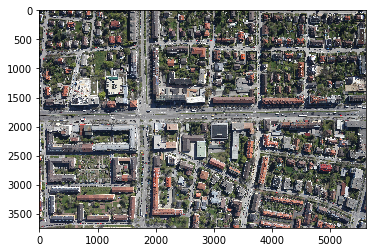

In [19]:
full_image = cv2.imread(im_p)
full_image = cv2.cvtColor(full_image, cv2.COLOR_BGR2RGB)
plt.imshow(full_image,vmin = 0,vmax = 255)
print(full_image.shape)

In [20]:
p = full_image.shape[1]
q = full_image.shape[0]
if p>224:
    new_x = (ceil(p/208)-1)*208 + 224
else:
    new_x = 224
if q>224:
    new_y = (ceil(q/208)-1)*208 + 224
else:
    new_y = 224

(3760, 5632, 3)


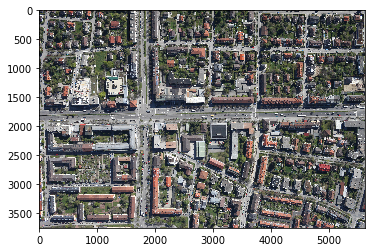

In [21]:
old_im = Image.open(im_p)
old_size = old_im.size

new_size = (new_x,new_y)
new_im = Image.new("RGB", new_size)   ## luckily, this is already black!
new_im.paste(old_im, ((int)((new_size[0]-old_size[0])/2), (int)((new_size[1]-old_size[1])/2)))
full_image = np.asarray(new_im,dtype = np.float32)
plt.imshow(full_image/255,vmin = 0,vmax = 255)
print(full_image.shape)

In [22]:
@jit(["void(float32,float32,int64,int64)"])
def place(prediction,full_image_p,y,x):
    for i in range(224):
        for j in range(224):
            full_image_p[y + i][x + j] = max(full_image_p[y + i][x + j],prediction[0][i][j])

In [23]:
def cropper(x_img,x0,y0):
    x0_end = x0 + 224
    y0_end = y0 + 224
    cropped_img = x_img[x0:x0_end,y0:y0_end]
    return cropped_img

In [24]:
print(full_image.shape)
full_image_p = np.zeros((new_y,new_x),dtype = np.float32)
print(full_image_p.shape)

(3760, 5632, 3)
(3760, 5632)


In [25]:

dur_predict = 0
dur_place = 0
dur_crop = 0
start = timer()
for x in range(floor(new_x/208)):
    for y in range(floor(new_y/208)):
        start3 = timer()
        img_part = cropper(full_image,y*208,x*208) # overlap = 16 therefore (224 - 16 = 208)
        dur_crop = dur_crop + timer() - start3
        '''if y==0 and x==1:
            plt.imshow(img_part,vmin = 0,vmax = 255)
            img_part = np.asarray(img_part)
            print(img_part.shape)
        '''
        img_part = np.asarray(img_part)
        img_part = img_part.reshape((1,224,224,3))
        img_part = 255 - img_part
        start1 = timer()
        prediction = odmodel.predict(img_part)
        dur_predict = dur_predict + timer() - start1
        prediction = np.asarray(prediction,dtype = np.float32)
        prediction = prediction.reshape((1,224,224))
        start2 = timer()
        place(prediction,full_image_p,y*208,x*208)
        dur_place = dur_place + timer()- start2
        
duration = timer() - start
print(duration)
print(dur_crop)
print(dur_predict)
print(dur_place)
        

13.800099135027267
0.005216874647885561
13.186516508692876
0.430110635003075


float32
float32
float32


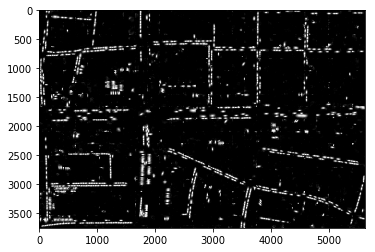

In [26]:
plt.imshow(full_image_p,cmap='gray',vmin = 0,vmax = 255)
temp = full_image_p

252
176
168
165
Total cars predicted =  1012
0.7202439439715818


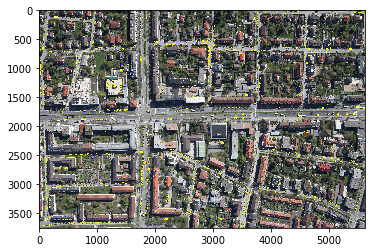

In [27]:
start = timer()
bounded_image = predictor(temp,full_image/255)
duration = timer() - start
print(duration)

In [ ]:
sm.imsave('2_concomp.jpg',bounded_image)